# Homework 3 (preliminary analysis part)

#### Kaggle team: < >
#### Group: A0148008J, 


## Importing, Constants, and data loading functions

In [12]:
# import statement and extra libraries used
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import sklearn
import statistics as st
import xgboost as xgb
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timedelta


In [2]:
# Constant used in this homework
DATE_TIME_FORMAT_DEV = "%d/%m/%Y"
DATE_TIME_FORMAT_REAL = "%Y-%m-%d"
DATE_TIME_FORMAT_WEEK = "%Y-W%W-%w"
MIN_BOOLEAN_INDEX_TRAIN = 5
MAX_BOOLEAN_INDEX_TRAIN = 8
RAW_FEATURE_NUMBER_TRAIN = 9
MIN_BOOLEAN_INDEX_TEST = 4
MAX_BOOLEAN_INDEX_TEST = 7
RAW_FEATURE_NUMBER_TEST = 8
STORE_COMPETITION_SINCE_DEFAULT_TIME = datetime(2009, 3, 9, 18, 13, 5)
STORE_NO_PROMOTION_SINCE_CONSTANT_TIME = datetime(2999, 1, 1, 0, 0, 0) # we assume this datetime is big enough
STORE_NO_COMPETITION_SINCE_CONSTANT_TIME = datetime(2999, 1, 1, 0, 0, 0) # we assume this datetime is big enough
STORE_NO_PROMO_INTERVAL_STRING = "No Promotion"

In [3]:
# File path processing
current_pwd = os.getcwd()
directory_path = os.path.join(current_pwd, "inpublic/homework3")
train_file_path = os.path.join(directory_path, "train_v2.csv")
test_file_path = os.path.join(directory_path, "test_v2.csv")
store_info_path = os.path.join(directory_path, "store.csv")

In [4]:
# data loading and extraction function
def dataLoadExtract(filePath, booleanMin, booleanMax):
    rawDataMatrix = []
    firstRow = True
    
    with open(filePath, newline='') as csvFile:
        train_raw = csv.reader(csvFile, delimiter=',')
        for row in train_raw:
            if (firstRow):
                rawDataMatrix.append(row)
                firstRow = False
            else:
                currentRow = []
                for i in range(len(row)):
                    if (i == 7):
                        currentRow.append(row[i])
                    elif booleanMin<=i<=booleanMax:
                        if (row[i] == '0'):
                            currentRow.append(False)
                        else:
                            currentRow.append(True)
                    elif '-' in row[i]:
                        currentRow.append(
                            datetime.strptime(row[i], DATE_TIME_FORMAT_REAL).date())
                    else:
                        currentRow.append(int(row[i]))
                rawDataMatrix.append(currentRow)
    
    headerRaw = rawDataMatrix[0] # a list containing all the headers as string
    dataRaw = np.array(rawDataMatrix[1:]) # a numpy array with raw data
    return headerRaw, dataRaw

In [5]:
def storeLoadExtract(filePath):
    rawDataMatrix = []
    firstRow = True
    
    with open(filePath, newline='') as csvFile:
        train_raw = csv.reader(csvFile, delimiter=',')
        for row in train_raw:
            if (firstRow):
                header = ["Store Index", "Store Type", "Assortment", "Competition distance reciprocal", "Competition Since",
                          "Promotion Since", "Promotion Interval"]
                rawDataMatrix.append(header)
                firstRow = False
            else:
                currentRow = []
                currentRow.append(int(row[0])) # store index
                currentRow.append(row[1]) # store type
                currentRow.append(row[2]) # assortment
                
                if (row[3] == ""): # competition distance reciprocal
                    currentRow.append(0)
                    currentRow.append(STORE_NO_COMPETITION_SINCE_CONSTANT_TIME)
                else:
                    currentRow.append(1.0/int(row[3])) 
                
                    if (row[4] != ""): 
                        date_str = "1/"+row[4]+"/"+row[5]
                        date_object = datetime.strptime(date_str, DATE_TIME_FORMAT_DEV)
                        currentRow.append(date_object) # competition since time
                    else:
                        currentRow.append(STORE_COMPETITION_SINCE_DEFAULT_TIME)
                
                if (row[6] == "0"): # promotion specs
                    currentRow.append(STORE_NO_PROMOTION_SINCE_CONSTANT_TIME)
                    currentRow.append(STORE_NO_PROMO_INTERVAL_STRING)
                else:
                    date_str = row[8]+"-W"+row[7]+"-0"
                    date_object = datetime.strptime(date_str, DATE_TIME_FORMAT_WEEK)
                    currentRow.append(date_object)
                    currentRow.append(row[9])

                rawDataMatrix.append(currentRow)
    
    headerRaw = rawDataMatrix[0] # a list containing all the headers as string
    dataRaw = np.array(rawDataMatrix[1:]) # a numpy array with raw data
    return headerRaw, dataRaw
    

## Data Loading _(Test_v2.csv, train_v2.csv, store.csv)_

In [6]:
# Data loading and extraction
headerRawTrain, dataRawTrain = dataLoadExtract(train_file_path, MIN_BOOLEAN_INDEX_TRAIN, MAX_BOOLEAN_INDEX_TRAIN)
headerRawTest, dataRawTest = dataLoadExtract(test_file_path, MIN_BOOLEAN_INDEX_TEST, MAX_BOOLEAN_INDEX_TEST)
headerRawStore, dataRawStore = storeLoadExtract(store_info_path)

## Preliminary Analysis

#### Preliminary analysis for store.csv

In [8]:
# Preliminary analysis for store.csv
rawDataMatrix = []
timeList = []
firstRow = True
current = 0
distance_max = 0
distance_min = 999999999999999999
promo_interval = []
with open(store_info_path, newline='') as csvFile:
    train_raw = csv.reader(csvFile, delimiter=',')
    for row in train_raw:
        
    
        if (firstRow):
            header = row
            firstRow = False
        
        else:
            if (row[4]!=""):
                date_str = "1/"+row[4]+"/"+row[5]
                # print(date_str)
                currentCompetitionTime = (datetime.strptime(date_str, DATE_TIME_FORMAT_DEV)-datetime(1970,1,1)).total_seconds()
                timeList.append(currentCompetitionTime)
            if (int(row[0]) > current):
                current = int(row[0])
            if (row[3] == ""):
                continue
            else:
                if (int(row[3]) > distance_max):
                    distance_max = int(row[3])
                if (int(row[3]) < distance_min):
                    distance_min = int(row[3])
            if (row[9]!="" and row[9] not in promo_interval):
                promo_interval.append(row[9])
            
# Printing statements:      
print(header)
print(current)
print(distance_min)
print(distance_max)
print(promo_interval)
average_time = datetime.fromtimestamp(round(sum(timeList)/len(timeList)))
average_time

['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
1115
20
75860
['Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec']


datetime.datetime(2009, 3, 9, 18, 13, 5)

#### Preliminary analysis for train_v2.csv

In [9]:
# Preliminary analysis for train_v2.csv
rawDataMatrix = []
firstRow = True
sales_min = customers_min = 99999999999999999
sales_max = customers_max = 0

# Further checking on column relations
close_then_sales_equal_zero = True
sales_equal_zero_then_it_close = True
state_holiday_then_close = True
state_holiday_then_school_holiday = True

for row in dataRawTrain:
    if (row[5] is False and row[3] != 0):
        close_then_sales_equal_zero = False
    
    if (row[3] == 0 and row[5] is True):
        sales_equal_zero_then_it_close = False
    
    if (row[7] == 1):
        if (row[5] != 0):
            # checking state and close relation
            state_holiday_then_close = False
            
        elif (row[8] == 0) :
            # checking state and school relation
            state_holiday_then_school_holiday = False
    
        
print(headerRawTrain)
print(close_then_sales_equal_zero)
print(sales_equal_zero_then_it_close)
print(state_holiday_then_close)
print(state_holiday_then_school_holiday)

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
True
True
True
True


#### Preliminary visualization analysis (some parts are omitted, graphs are shown in the readme file)

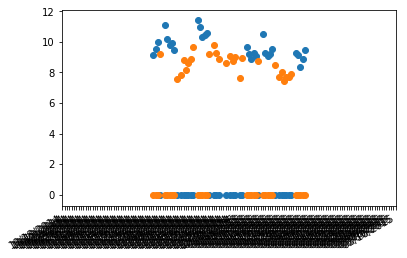

In [14]:
# Printing for different store past sales information (random sampling) 
#for store_number in [1, 500, 1000]:
# processed_data = []
nonPromotion_ratio = []
Promotion_ratio = []
time_list = []
for row in dataRawTrain:
    if (row[0] == 2):
        if (row[3]==0):
            continue
        #if (row[0] ==store_number):
        time_list.append(row[2])
        if (row[6] is True):
            Promotion_ratio.append(int(row[3])/int(row[4]))
            nonPromotion_ratio.append(0)
        elif (row[6] is False):
            nonPromotion_ratio.append(int(row[3])/int(row[4]))
            Promotion_ratio.append(0)
# processed_array = np.array(processed_data)

x = np.array(time_list)
y1 = np.array(Promotion_ratio) # blue
y2 = np.array(nonPromotion_ratio) # orange

# print(date)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.scatter(x,y1,cmap=3)
plt.scatter(x,y2,cmap=2)
plt.gcf().autofmt_xdate()
plt.show() # please ignore the zero value at the bottom

